In [33]:
from scipy.fft import fft, ifft, fftfreq, rfft
import numpy as np

from matplotlib import pyplot as plt
import scanpy as sc
import seaborn as sns
import pandas as pd

import matplotlib

import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

import core.deconV as dV
from core.base import NSM, MSEM
import core.plot as pl

In [34]:
adata = sc.read_csv("../../data/GSE136148/sc.tsv", delimiter="\t")
bdata = sc.read_csv("../../data/GSE136148/bulk.tsv", delimiter="\t")
pdata = pd.read_csv("../../data/GSE136148/pdata.tsv", delimiter="\t", index_col=0)
bdata.var_names_make_unique()

/home/lutrarutra/mambaforge/envs/lst/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [35]:
adata.obs.loc[pdata.index, "cell_type"] = pdata["cellType"].astype("category")
adata = adata[adata.obs["cell_type"].astype(str).isin(["0", "1", "2"]), :]
adata.obs.groupby("cell_type").apply(len)

cell_type
0    1988
1     686
2     319
dtype: int64

In [36]:
adata.var["mt"] = adata.var_names.str.startswith("MT.")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=False, log1p=False, inplace=True)

/tmp/ipykernel_25469/2980942130.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["mt"] = adata.var_names.str.startswith("MT.")


In [37]:
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

common_genes = list(set(adata.var.index.values).intersection(set(bdata.var.index.values)))
adata = adata[:,common_genes].copy()
bdata = bdata[:,common_genes].copy()

In [38]:
# sc.pp.normalize_total(adata, target_sum=None, key_added="norm_factor", exclude_highly_expressed=True)
# sc.pp.normalize_total(bdata, target_sum=adata.X.sum(axis=1).mean())

sc.pp.normalize_total(bdata, target_sum=None)
# sc.pp.normalize_total(adata, target_sum=bdata.X.sum())
sc.pp.normalize_total(adata, target_sum=None)

In [42]:
adata.X.sum(1)

array([18256.   , 18255.998, 18256.   , ..., 18256.   , 18256.   ,
       18256.   ], dtype=float32)

In [28]:
bdata.X.shape

(1, 18068)

In [30]:
adata.var["pseudo"] = np.asarray(adata.X.mean(axis=0)).flatten()
adata.var["bulk"] = np.asarray(bdata.X[0])

adata.var["log_bulk"] = np.log1p(adata.var["bulk"])
adata.var["log_pseudo"] = np.log1p(adata.var["pseudo"])

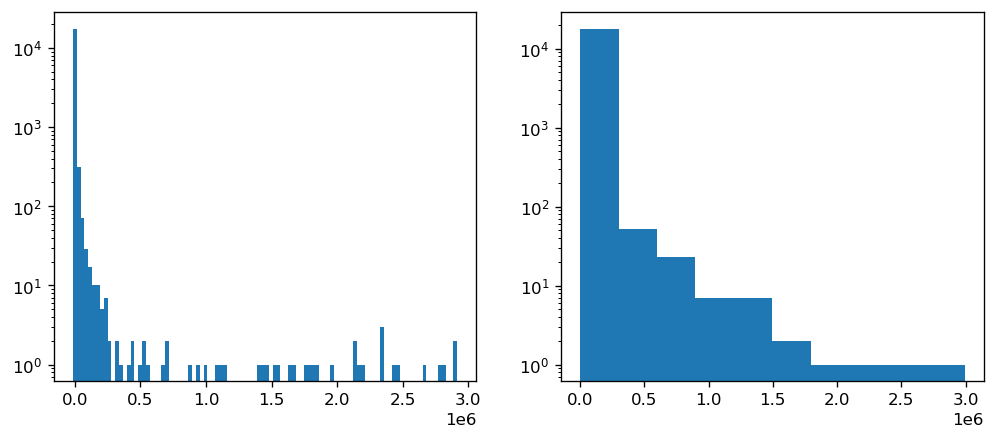

In [31]:
f, ax = plt.subplots(1, 2, figsize=(10,4), dpi=120)
hist, bins = np.histogram(adata.var["bulk"], bins=100)
ax[0].bar(bins[:-1], hist, width=np.diff(bins))
ax[1].hist(adata.var["pseudo"])
# ax[1].hist(adata.var["pseudo"], bins=bins[:-1])
ax[0].set_yscale("log")
ax[1].set_yscale("log")
plt.show()

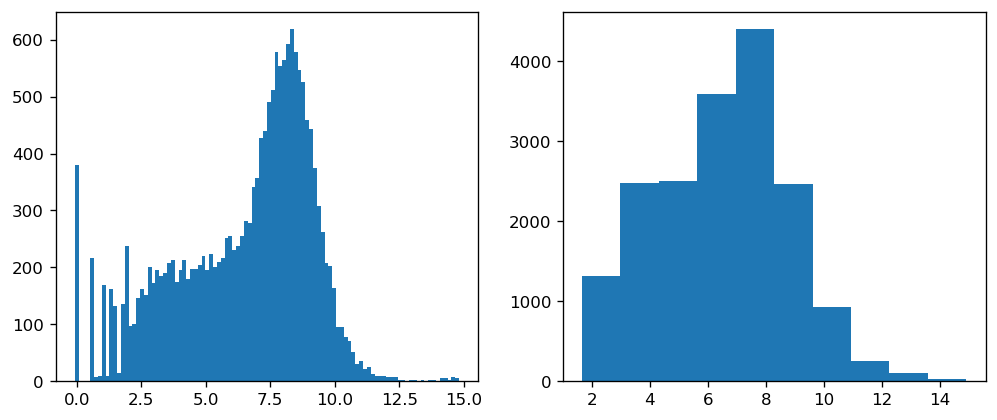

In [32]:
f, ax = plt.subplots(1, 2, figsize=(10,4), dpi=120)
hist, bins = np.histogram(adata.var["log_bulk"], bins=100)
ax[0].bar(bins[:-1], hist, width=np.diff(bins))
ax[1].hist(adata.var["log_pseudo"])
# ax[1].hist(adata.var["log_pseudo"], bins=bins[:-1])
# ax[0].set_yscale("log")
# ax[1].set_yscale("log")
plt.show()

In [9]:
adata.var_keys()

['mt',
 'n_cells_by_counts',
 'mean_counts',
 'pct_dropout_by_counts',
 'total_counts',
 'n_cells',
 'pseudo',
 'bulk',
 'log_bulk',
 'log_pseudo']

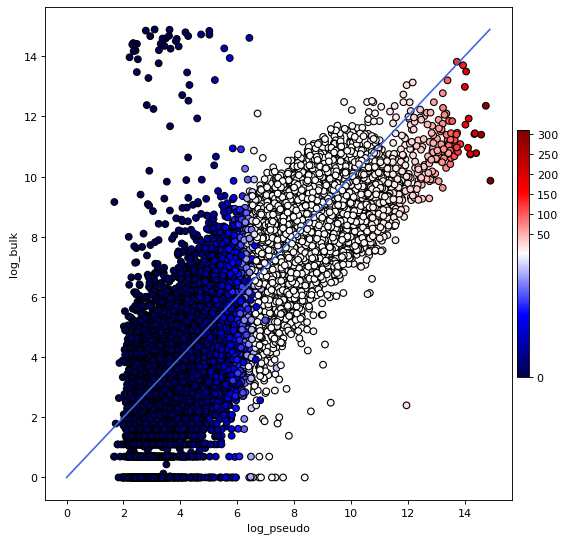

In [10]:
def pseudo_bulk_plot(adata, hue, title):
    normalize = matplotlib.colors.TwoSlopeNorm(vmin=0.0, vcenter=adata.var[hue].median(), vmax=adata.var[hue].max())
    colormap = "seismic"
    f, ax = plt.subplots(1, 1, figsize=(8,8), dpi=80)

    sns.scatterplot(
        data=adata.var, x="log_pseudo", y="log_bulk", c=adata.var[hue],
        edgecolor=(0,0,0,1), ax=ax, linewidth=1, cmap=colormap, norm=normalize
    ).set_title(title)

    ax.plot([0, adata.var["log_bulk"].max()], [0, adata.var["log_bulk"].max()], label="y=x", c="royalblue")

    if hue:
        scalarmappaple = matplotlib.cm.ScalarMappable(norm=normalize, cmap=colormap)
        scalarmappaple.set_array(adata.var[hue])
        f.colorbar(scalarmappaple, fraction=0.05, pad=0.01, shrink=0.5)

    # ax.set_xscale("log")
    # ax.set_yscale("log")
    # plt.savefig(f"../temp/log/{title}.png", dpi=120)
    plt.show()

pseudo_bulk_plot(adata, "mean_counts", "")

In [11]:
X = []

for i, cell_type in enumerate(adata.obs["cell_type"].cat.categories):
    _x = adata[adata.obs["cell_type"] == cell_type, :].X  
    X.append(torch.tensor(_x))

In [12]:
loc = torch.empty(adata.n_vars, 3)
scale = torch.empty(adata.n_vars, 3)

for i in range(len(X)):
    loc[:, i] = X[i].mean(0)
    scale[:, i]  = X[i].std(0)

assert torch.isnan(loc).sum() == 0, "NaN found in loc"
assert torch.isnan(scale).sum() == 0, "NaN found in scale"

In [13]:
def fmt_c(w):
    return " ".join([f"{v:.2f}" for v in w])

In [14]:
model = NSM(loc, scale)
Y = torch.tensor(bdata.X[0])
Y

optim = torch.optim.Adam(model.parameters(), lr=0.001)
pbar = tqdm.tqdm(range(100000))
for i in pbar:
    optim.zero_grad()
    loss = model(Y)
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.00001)
    optim.step()
    if i % 50 == 0:
        pbar.set_postfix({
            "loss":f"{loss.item():.1f}",
            "props" : fmt_c(model.get_proportions()),
            "lib_size": f"{model.lib_size.data.exp():.1f}"}
        )

100%|██████████| 100000/100000 [01:42<00:00, 972.91it/s, loss=117.0, props=0.48 0.29 0.23, lib_size=273.8]


In [15]:
w = model.get_proportions().detach()
w.sum()

tensor(1.)

In [16]:
adata.var["pred"] = (loc * w * model.lib_size.detach().exp()).sum(1)
adata.var["log_pred"] = np.log1p(adata.var["pred"])

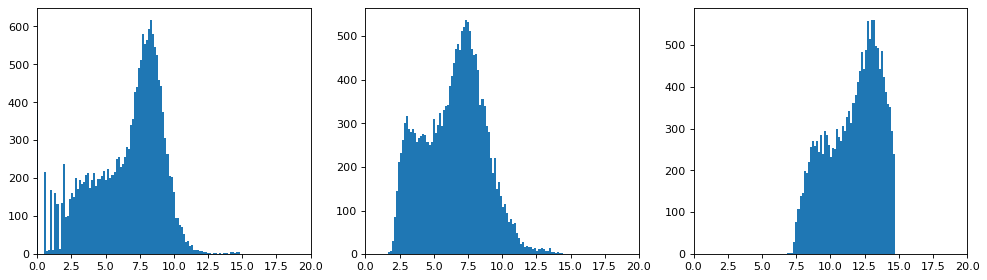

In [17]:
f, ax = plt.subplots(1, 3, figsize=(15,4), dpi=80)
hist, bins = np.histogram(adata.var["log_bulk"], bins=100)
ax[0].bar(bins[:-1], hist, width=np.diff(bins))
ax[1].hist(adata.var["log_pseudo"], bins=bins[:-1])
ax[2].hist(adata.var["log_pred"], bins=bins[:-1])
# ax[0].set_yscale("log")
# ax[1].set_yscale("log")
ax[0].set_xlim(0, 20)
ax[1].set_xlim(0, 20)
ax[2].set_xlim(0, 20)
plt.show()

In [18]:
adata.var["log_bulk"].sum()

118218.42

In [19]:
adata.var["log_pseudo"].sum()

117134.23

In [20]:
adata.var["log_pred"].sum()

219038.5